In [ ]:
# Importing the usewfule libraries
from collections import OrderedDict
import re
from typing import Type, Any, Callable, Union, List, Optional
import glob
import os
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.utils.data import Dataset
from torch import optim
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset,DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable

import random
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import ShuffleSplit
import cv2

import skimage
import skimage.segmentation
import skimage.io
from skimage import feature
from skimage import filters
from skimage.color import rgb2gray

import copy

import math

import imageio

import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm

import nibabel as nib

from scipy import signal
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import distance_transform_edt



# Data pre-processing and saving

In [ ]:
!unzip '/content/drive/MyDrive/Training_Batch1.zip' -d 'images'
!unzip '/content/drive/MyDrive/Training_Batch2.zip' -d 'images'

In [ ]:
# Clipping the 3D voxel values between -100 and 300
def clip_voxels(volume, lower=-100, upper=300):
    return np.clip(volume, lower, upper)

# Rescaling the 3D voxel values between 0 and 255
def rescale_voxels(volume, new_min=0, new_max=255):
    min_val = np.min(volume)
    max_val = np.max(volume)
    return new_min + ((volume - min_val) * (new_max - new_min) / (max_val - min_val))

# Applying gamma correction to the 3D voxel values to enhance the contrast
def apply_gamma_correction(volume):
    return np.power(volume, 2)

# Converting 3D NIfTI files to 2D slices
def convert_3d_to_2d(input_folder, output_folder1,output_folder2):
    # Create output directory if it doesn't exist
    os.makedirs(output_folder1, exist_ok=True)
    os.makedirs(output_folder2, exist_ok=True)

    # Get the list of NIfTI files in both folders
    files = sorted([f for f in os.listdir(input_folder) if f.endswith('.nii') or f.endswith('.nii.gz')])

    for filename in files:
        if "segmentation" in os.path.splitext(filename)[0]:
          nifti_file_mask = os.path.join(input_folder, filename)
          nifti_img_mask = nib.load(nifti_file_mask)
          mask_data = nifti_img_mask.get_fdata()

          image_file_name = filename.replace('segmentation','volume')
          nifti_file_image = os.path.join(input_folder, image_file_name)
          nifti_img_image = nib.load(nifti_file_image)
          image_data = nifti_img_image.get_fdata()

          # count the number of non-zeros voxels and average
          count_ones_twos = np.isin(mask_data, [1, 2]).sum(axis=(0, 1))
          k_values = count_ones_twos / (mask_data.shape[0] * mask_data.shape[1])
          valid_indices = np.where(k_values > 0.1)[0]

          # Select valid slices which have more than 10% of liver or tumor pixels
          image = image_data[:, :, valid_indices]
          mask = mask_data[:, :, valid_indices]

          if image.size != 0:
            # Clip voxel values between -100 and 300
            image = clip_voxels(image)
            # rescale the voxels between 0 and 255
            image = rescale_voxels(image)
            # apply gamma correction
            image = apply_gamma_correction(image)
            # rescale the voxels between 0 and 255
            image = rescale_voxels(image)

            # downsampling the input images, to fit into the model to 128x128
            q = 4
            image = signal.decimate(image, q, axis = 0)
            image = signal.decimate(image, q, axis = 1)
            mask = signal.decimate(mask, q, axis = 0)
            mask = signal.decimate(mask, q, axis = 1)
            num_slices = image.shape[2]
            for i in range(num_slices):
              slice_2d_image = image[:, :, i]
              slice_2d_mask = mask[:, :, i]
              output_filename1 = f"{os.path.splitext(image_file_name)[0]}_slice_{i+1}.npy"
              output_file_path1 = os.path.join(output_folder1, output_filename1)
              np.save(output_file_path1, slice_2d_image)
              print(f"Saved {output_file_path1}")
              output_filename2 = f"{os.path.splitext(filename)[0]}_slice_{i+1}.npy"
              output_file_path2 = os.path.join(output_folder2, output_filename2)
              np.save(output_file_path2, slice_2d_mask)
              print(f"Saved {output_file_path2}")


input_folder = '/content/images2/media/nas/01_Datasets/CT/LITS/Training Batch 1/'
output_folder1 = '/content/drive/MyDrive/lits_dataset/images/'
output_folder2 = '/content/drive/MyDrive/lits_dataset/masks/'

convert_3d_to_2d(input_folder, output_folder1, output_folder2)


Setting the initial settings

In [ ]:
cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")
seed = 1234
train_batch_size = 16
inference_batch_size = 16

In [ ]:
image_path_train=glob.glob('/content/drive/MyDrive/lits_dataset/images/**.npy')
image_path_train.sort()
label_path_train=glob.glob('/content/drive/MyDrive/lits_dataset/masks/**.npy')
label_path_train.sort()

# Custom dataset class for loading the images and masks
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths):

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        min_intensity = 0
        max_intensity = 255
        # Normalizing the images
        self.transform1 = transforms.Compose([
                transforms.Lambda(lambda x: (x - min_intensity) / (max_intensity - min_intensity)),
                transforms.Lambda(lambda x: x.clamp(0, 1)),
                ])
    def __getitem__(self, index):
        image = np.load(self.image_paths[index])
        image = torch.from_numpy(image).unsqueeze(0)
        image = self.transform1(image)
        mask = np.load(self.mask_paths[index])
        # Clipping the mask values between 0 and 1
        mask[mask>1]=1
        mask = torch.from_numpy(mask).unsqueeze(0)
        mask = (mask > 0.5).float()
        return image, mask

    def __len__(self):
        return len(self.image_paths)

# Creating the dataloader
train_dataset = CustomDataset(image_path_train,label_path_train)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)


In [ ]:
# Total number of images and masks in the training dataset
print(len(image_path_train))
print(len(label_path_train))

5791
5791


In [ ]:
# Splitting the dataset into training and testing
segmentation_image_train = image_path_train[:int(len(image_path_train)*0.8)]
segmentation_image_test = image_path_train[int(len(image_path_train)*0.8):]
segmentation_image_train.sort()
segmentation_image_test.sort()
segmentation_label_train = label_path_train[:int(len(image_path_train)*0.8)]
segmentation_label_test = label_path_train[int(len(image_path_train)*0.8):]
segmentation_label_train.sort()
segmentation_label_test.sort()

# Creating the dataloader for training and testing
segmentation_train_dataset = CustomDataset(segmentation_image_train,segmentation_label_train)
segmentation_test_dataset = CustomDataset(segmentation_image_test,segmentation_label_test)

seg_train_dl = torch.utils.data.DataLoader(segmentation_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
seg_test_dl = torch.utils.data.DataLoader(segmentation_test_dataset, batch_size=inference_batch_size, shuffle=False, num_workers=2)

In [ ]:
print(len(segmentation_train_dataset))
print(len(segmentation_test_dataset))

4632
1159


# Segmentation

In [ ]:
""" Link: https://github.com/milesial/Pytorch-UNet """

# Defining the building blocks of the UNet model
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        # Applying two 3x3 convolutions with batch normalization and ReLU activation as convolutional blocks
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Defining the downsampling block
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Applying maxpool of 2x2 and then applying the double convolution block
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Defining the upsampling block
class Up(nn.Module):
   
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # If bilinear interpolation is used, the upsampling is done using bilinear interpolation
        # Upsampling scale factor is 2 by default
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Padding the input tensor to match the output tensor size
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Calculating the padding values
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenating the tensors
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defining the output layer
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Defining the UNet model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        #Defining the upsampling and downsampling blocks
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        # First down sampling to 1024 channels and then upsampling to 64 channels
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

# Moving the model to the GPU
segmentor = UNet(1,1).cuda()

In [ ]:
# Intersection over Union (IoU) metric
class Metric(nn.Module):
    def __init__(self, threshold=0.5):
        super(Metric, self).__init__()
        self.threshold = threshold

    def forward(self, target, input):
        eps = 1e-10
        input_ = (input > self.threshold).data.float()
        target_ = (target > self.threshold).data.float()
        intersection = torch.clamp(input_ * target_, 0, 1)
        union = torch.clamp(input_ + target_, 0, 1)
        if torch.mean(intersection).lt(eps):
            return torch.Tensor([0., 0., 0., 0.])
        else:
            acc = torch.mean((input_ == target_).data.float())
            iou = torch.mean(intersection) / torch.mean(union)
            recall = torch.mean(intersection) / torch.mean(target_)
            precision = torch.mean(intersection) / torch.mean(input_)
            return torch.Tensor([acc, recall, precision, iou])
metrics=Metric()

In [ ]:
# Using the Adam optimizer
optimizer = torch.optim.Adam(segmentor.parameters(),lr=0.001)

In [ ]:
# Binary cross entropy loss
bce_loss = nn.BCELoss()

In [ ]:
# Training the model for Segmentation for 1000 epochs and save the model states every 50 epochs
path = '/content/drive/MyDrive/model_states/segmentation/'
for epoch in range(1000):
    epoch_loss = 0
    metric_epoch = 0
    for batch_idx, (images,labels) in tqdm(enumerate(seg_train_dl), total=len(seg_train_dl)):
        images = images.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)
        images = images.cuda()
        labels = labels.cuda()
        pred = segmentor(images)
        loss = bce_loss(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric=metrics(labels,pred)
        epoch_loss += loss.item()
        metric_epoch += metric
    print(f"Epoch [{epoch + 1}/100], Loss: {epoch_loss / len(seg_train_dl)}")
    print(f"Epoch [{epoch + 1}/100], Metrics: {metric_epoch / len(seg_train_dl)}")
    path_final=os.path.join(path,f"unet{epoch % 50}")
    torch.save(segmentor.state_dict(), path_final)

In [ ]:
# Loading the trained model from the saved model states
segmentor.load_state_dict(torch.load('/content/drive/MyDrive/model_states/segmentation/unet'))

<ipython-input-6-77f0a9a6e1a3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentor.load_state_dict(torch.load('/content/drive/MyDrive/model_states/segmentation/unet')

<All keys matched successfully>

In [ ]:
# Evaluating the model on the test dataset
segmentor.eval()
epoch_loss = 0
metric_epoch = 0
for batch_idx, (images,labels) in tqdm(enumerate(seg_test_dl), total=len(seg_test_dl)):
        images = images.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)
        images = images.cuda()
        labels = labels.cuda()
        pred = segmentor(images)
        metric=metrics(labels,pred)
        metric_epoch += metric
print(f"Epoch [{epoch + 1}/100], Loss: {epoch_loss / len(seg_test_dl)}")
print(f"Epoch [{epoch + 1}/100], Metrics: {metric_epoch / len(seg_test_dl)}")


# DDPM

In [ ]:
img_size = (128,128,1)
n_layers = 8
n_timesteps = 1000
beta_minmax= [1e-4, 0.05]
lr = 5e-5

In [ ]:
""" Link: https://github.com/milesial/Pytorch-UNet """

# Defining the building blocks of the UNet model
class DoubleConv1(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        # Applying two 3x3 convolutions with batch normalization and ReLU activation as convolutional blocks
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Defining the downsampling block
class Down1(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Applying maxpool of 2x2 and then applying the double convolution block
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Defining the upsampling block
class Up1(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # If bilinear interpolation is used, the upsampling is done using bilinear interpolation
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Upsampling the input tensor
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # Padding the input tensor to match the output tensor size
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defining the output layer
class OutConv1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv1, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Defining the UNet model
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
       # Defining the upsampling to 1024 channels and downsampling blocks to 64 channels
        self.inc = (DoubleConv1(n_channels, 64))
        self.down1 = (Down1(64, 128))
        self.down2 = (Down1(128, 256))
        self.down3 = (Down1(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down1(512, 1024 // factor))
        self.up1 = (Up1(1024, 512 // factor, bilinear))
        self.up2 = (Up1(512, 256 // factor, bilinear))
        self.up3 = (Up1(256, 128 // factor, bilinear))
        self.up4 = (Up1(128, 64, bilinear))
        self.outc = (OutConv1(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

DDPM_UNet = Unet(1,1)

In [ ]:
"https://github.com/lucidrains/denoising-diffusion-pytorch/"

# Defining the diffusion model
class Diffusion(nn.Module):
    """
    A PyTorch implementation of the Diffusion model for image generation.
    Attributes:
        n_times (int): Number of diffusion steps.
        img_H (int): Height of the input image.
        img_W (int): Width of the input image.
        img_C (int): Number of channels in the input image.
        model (nn.Module): The neural network model used for predicting noise.
        sqrt_betas (torch.Tensor): Square root of the beta values.
        alphas (torch.Tensor): Alpha values.
        sqrt_alphas (torch.Tensor): Square root of the alpha values.
        sqrt_one_minus_alpha_bars (torch.Tensor): Square root of (1 - alpha_bar) values.
        sqrt_alpha_bars (torch.Tensor): Square root of the alpha_bar values.
        device (str): Device to run the model on ('cuda' or 'cpu').
    Methods:
        extract(a, t, x_shape):
            Extracts the values from tensor `a` at indices `t` and reshapes to `x_shape`.
        scale_to_minus_one_to_one(x):
            Scales the input tensor `x` from [0, 1] to [-1, 1].
        reverse_scale_to_zero_to_one(x):
            Scales the input tensor `x` from [-1, 1] to [0, 1].
        make_noisy(x_zeros, t):
            Adds noise to the input tensor `x_zeros` at time step `t`.
        forward(x_zeros):
            Forward pass of the model. Perturbs the input images and predicts the noise.
        denoise_at_t(x_t, timestep, t):
            Denoises the input tensor `x_t` at a specific time step `t`.
        sample(N):
            Generates `N` samples by iteratively denoising random noise.
    """

    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution
        self.model = model
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device)
        self.sqrt_betas = torch.sqrt(betas)
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        self.device = device

    #Extracts the values from tensor `a` at indices `t` and reshapes to `x_shape`.
    def extract(self, a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    # Scales the input tensor `x` from [0, 1] to [-1, 1].
    def scale_to_minus_one_to_one(self, x):
        return x * 2 - 1

    # Scales the input tensor `x` from [-1, 1] to [0, 1].
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    # Adds noise to the input tensor `x_zeros` at time step `t`.
    def make_noisy(self, x_zeros, t):
        epsilon = torch.randn_like(x_zeros).to(self.device)
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
        return noisy_sample.detach(), epsilon


    #  Forward pass of the model. Perturbs the input images and predicts the noise.
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        B, _, _, _ = x_zeros.shape
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        pred_epsilon = self.model(perturbed_images)
        return perturbed_images, epsilon, pred_epsilon


    # Denoises the input tensor `x_t` at a specific time step `t`.
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        epsilon_pred = self.model(x_t)
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        return x_t_minus_1.clamp(-1., 1)

    #  Generates `N` samples by iteratively denoising random noise.
    def sample(self, N):
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0

# Creating the diffusion model
diffusion = Diffusion(DDPM_UNet, image_resolution=img_size, n_times=n_timesteps,
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

# Using the Adam optimizer, and Mean Squared Error (MSE) loss
optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

# Counting the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  31036481


In [ ]:
path = '/content/drive/MyDrive/model_states/DDPM/'

epochs = 1000


print("Start training DDPMs...")
diffusion.train()

# Training the diffusion model for 1000 epochs and save the model states every 50 epochs
for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x,labels) in tqdm(enumerate(train_dl), total=len(train_dl)):
        optimizer.zero_grad()
        x = x.type(torch.FloatTensor)
        x = x.to(DEVICE)
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        noise_prediction_loss += loss.item()
        loss.backward()
        optimizer.step()
    path_final=os.path.join(path,f"DDPM{epoch % 50}")
    torch.save(diffusion.state_dict(), path_final)
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)


print("Finish!!")


In [ ]:
# Plotting the denoised images
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy(), cmap = 'gray')


In [ ]:
# Loading the trained model from the saved model states
diffusion.load_state_dict(torch.load('/content/drive/MyDrive/model_states/DDPM/DDPM'))

<ipython-input-10-60a9c26a2ea8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion.load_state_dict(torch.load('/content/drive/MyDrive/model_states/DDPM/DDPM'))


<All keys matched successfully>

In [ ]:
# Generating the denoised images
diffusion.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

# show_image(generated_images, idx=0)

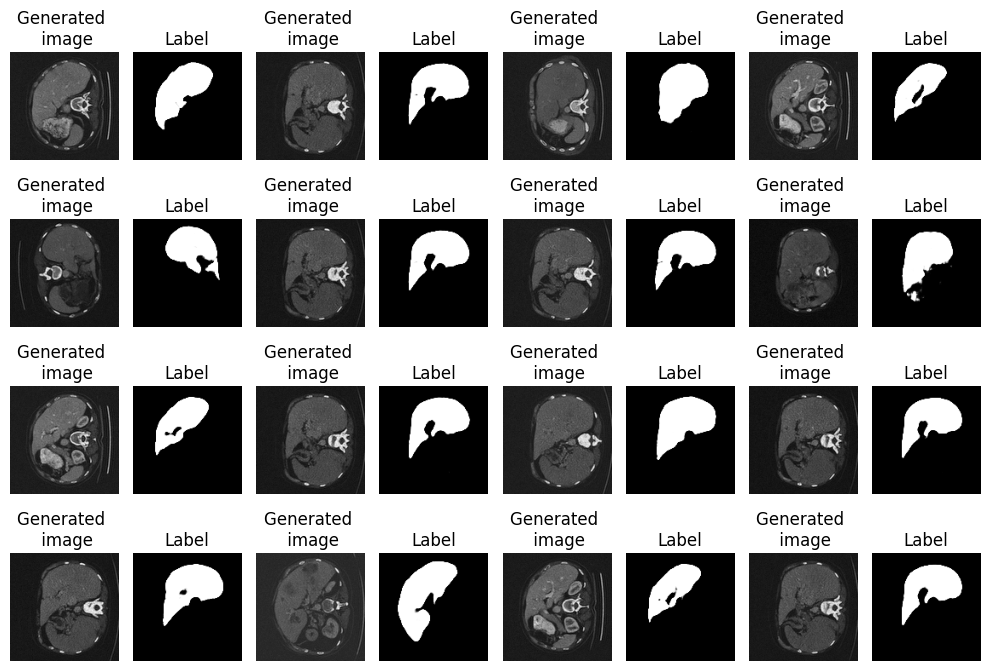

In [ ]:
# Plotting the generated images and labels
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 8
i = 0
diffusion.eval()
segmentor.eval()
for param in diffusion.parameters():
    param.requires_grad = False
for param in segmentor.parameters():
    param.requires_grad = False
with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)
# Segmenting liver from the generated images
with torch.no_grad():
    pred = segmentor(generated_images).cpu()
def show_image(x, idx):
    fig.add_subplot(rows, columns, idx+1)
    id = int(idx/2) if idx % 2 == 0 else int((idx-1)/2)
    plt.imshow(np.squeeze(x[id].detach().cpu().numpy(),axis=0),cmap = 'gray')
    plt.axis('off')
    titles = f'Generated \n image' if idx % 2 == 0 else 'Label'
    plt.title(titles)
x = generated_images.type(torch.FloatTensor)
label = pred.type(torch.FloatTensor)
while i < len(x)*2:
    input = x if i % 2 == 0 else label
    show_image(input, idx = i)
    i = i+1
plt.tight_layout()
plt.savefig(f'/content/Generated_image_DDPM.jpg',dpi=300)


In [ ]:
# Saving 1024 generated images in the drive
times = int(1024/inference_batch_size)
diffusion.eval()
for i in range(times):
  with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)
    for j in range(len(generated_images)):
      plt.imsave(f'/content/drive/MyDrive/lits_dataset_jpg/DDPM/Generated_image_iter{i}_{j}.jpg',np.squeeze(generated_images[j].detach().cpu().numpy()),cmap='gray')

# VAE

In [ ]:
# Defining the Encoder and Decoder for the VAE model
class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        # Upsampling the input images to 256*8*8
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
# Defining the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim=64):
        # Downsampling the input images to 1*32*32
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        # Decoding the latent space to the input images
        z = self.fc(z)
        z = z.view(z.size(0), 256, 8, 8)
        z = torch.relu(self.deconv1(z))
        z = torch.relu(self.deconv2(z))
        z = torch.relu(self.deconv3(z))
        z = torch.sigmoid(self.deconv4(z))
        return z

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    # Reparameterization trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

# Loss function for the VAE model (BCE + KLD)
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Hyperparameters
latent_dim = 64
learning_rate = 0.001

# Initialize VAE model, optimizer, and loss function
model = VAE(latent_dim).cuda()
optimizer = Adam(model.parameters(), lr=learning_rate)



In [ ]:

num_epochs = 500
path = '/content/drive/MyDrive/model_states/VAE/'

# Training the VAE model for 500 epochs and save the model states every epoch
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (x,_) in tqdm(enumerate(train_dl), total=len(train_dl)):
        data = x.type(torch.FloatTensor).cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    path_final=os.path.join(path,f"VAE{epoch}")
    torch.save(model.state_dict(), path_final)


In [ ]:
# Loading the trained model from the saved model states
model.load_state_dict(torch.load('/content/drive/MyDrive/model_states/VAE/VAE'))

<ipython-input-75-1dae0de009e9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/model_states/VAE/VAE'))


<All keys matched successfully>

<function matplotlib.pyplot.show(close=None, block=None)>

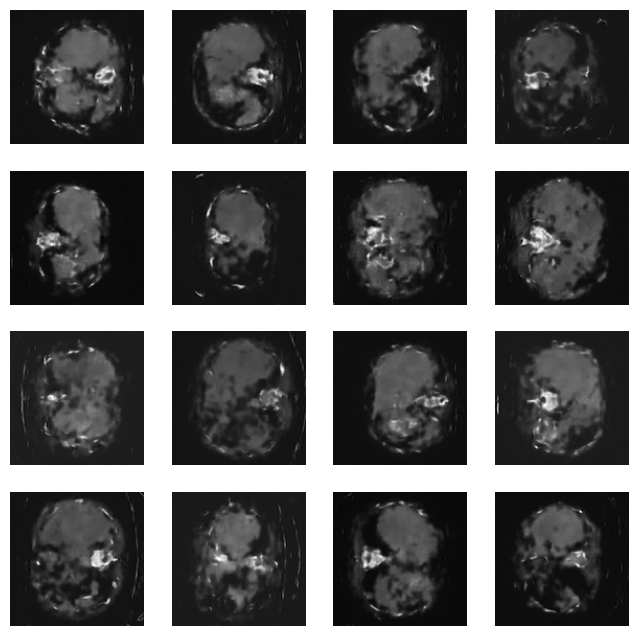

In [ ]:
# Generating the images using the VAE model
model.eval()
num_samples = inference_batch_size
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).cuda()
    generated_images = model.decoder(z)
    generated_images = generated_images.cpu()

plt.figure(figsize=(8, 8))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.show


In [ ]:
# Saving 1024 generated images in the drive
times = int(1024/inference_batch_size)
model.eval()
for i in range(times):
  with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).cuda()
    generated_images = model.decoder(z)
    generated_images = generated_images.cpu()
    for j in range(len(generated_images)):
      plt.imsave(f'/content/drive/MyDrive/lits_dataset_jpg/VAE/Generated_image_iter{i+46}_{j}.jpg',np.squeeze(generated_images[j].detach().cpu().numpy()),cmap='gray')

# FID Score

In [ ]:
!pip install torch torchvision numpy
!pip install pytorch-fid

In [ ]:
# Calculating the Frechet Inception Distance (FID) score
from pytorch_fid import fid_score
# Custom dataset class for loading the images
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
           image = self.transform(image)
        return image

# Function to compute the FID score
def compute_fid(real_images_folder, generated_images_folder):
    assert os.path.exists(real_images_folder), "Real images folder does not exist."
    assert os.path.exists(generated_images_folder), "Generated images folder does not exist."
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    real_dataset = CustomImageDataset(real_images_folder, transform=transform)
    generated_dataset = CustomImageDataset(generated_images_folder, transform=transform)

    real_loader = DataLoader(real_dataset, batch_size=32, shuffle=False)
    generated_loader = DataLoader(generated_dataset, batch_size=32, shuffle=False)

    fid_value = fid_score.calculate_fid_given_paths(
        [real_images_folder, generated_images_folder],
        batch_size=32,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        dims=2048
    )

    return fid_value

real_images_folder = '/kaggle/input/lits-images/images/'
generated_images_folder = '/kaggle/input/ddpm-output/DDPM_images/'

fid_score_value = compute_fid(real_images_folder, generated_images_folder)
print(f"FID Score: {fid_score_value}")


# SSIM

In [ ]:
!pip install torchmetrics
!pip install --upgrade torchmetrics

In [ ]:
from torchmetrics import StructuralSimilarityIndexMeasure
import os
from PIL import Image
import torch
from torchvision import transforms
import random

ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)

# Function to load and preprocess the images
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    img = transforms.ToTensor()(img)
    return img.unsqueeze(0)

real_folder = '/kaggle/input/lits-images/images/'
generated_folder = '/kaggle/input/ddpm-output/DDPM_images/'

# Function to calculate the SSIM score for a single image
def calculate_ssim_for_run():
    real_files = [f for f in os.listdir(real_folder) if f.lower().endswith('.jpg')]
    generated_files = [f for f in os.listdir(generated_folder) if f.lower().endswith('.jpg')]
    sampled_real_files = random.sample(real_files, len(generated_files))
    ssim_scores = []
    for real_file, generated_file in zip(sampled_real_files, generated_files):
        real_image_path = os.path.join(real_folder, real_file)
        generated_image_path = os.path.join(generated_folder, generated_file)
        img1 = load_and_preprocess_image(real_image_path)
        img2 = load_and_preprocess_image(generated_image_path)
        ssim_value = ssim_metric(img1, img2)
        ssim_scores.append(ssim_value.item())
    return sum(ssim_scores) / len(ssim_scores) if ssim_scores else 0

num_runs = 5
average_ssim_scores = [calculate_ssim_for_run() for _ in range(num_runs)]
final_average_ssim = sum(average_ssim_scores) / num_runs

print(f"Final Average SSIM Score over {num_runs} runs: {final_average_ssim}")


Interface

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [ ]:
import gradio as gr
import torch
from PIL import Image

# Function to generate the images using the trained model
def generate_image():
    with torch.no_grad():
      generated_images = diffusion.sample(N=inference_batch_size)
      label_images = segmentor(generated_images)
    image_out = Image.fromarray((generated_images[0].transpose(0, 1).transpose(1, 2).detach().cpu().squeeze().numpy() * 255).astype('uint8'))
    label_out = Image.fromarray((label_images[0].transpose(0, 1).transpose(1, 2).detach().cpu().squeeze().numpy() * 255).astype('uint8'))
    return image_out, label_out

# Creating the Gradio interface
with gr.Blocks() as demo:
    generate_button = gr.Button("Generate")
    output1 = gr.Image(label="Generated Image")
    output2 = gr.Image(label="Segmented Label")
    generate_button.click(generate_image, inputs=None, outputs=[output1, output2])

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://61b0b3fcae6d7b60bd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
